This program will allow the user to determine the presence of any solar radiation storms from user-provided GOES satellite data.
Make sure the EPEAD and HEPAD .csv files are saved to the same directory as this notebook file before running.

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
from pandas import *
from numpy import  *
from calendar import monthrange
import math
%matplotlib inline

In [2]:
#Step One - ask user to input year, month and satellite number
YYYY=input('Which year? (Enter 4 digit number) ')
MM=input('Which month? (Enter 2 digit number) ')
NN=input('Which GOES satellite? (Enter 2 digit number) ')
DD=str(monthrange(int(YYYY),int(MM))[1])


Which year? (Enter 4 digit number)  2011
Which month? (Enter 2 digit number)  03
Which GOES satellite? (Enter 2 digit number)  15


In [3]:
#Step Two - read in the CSV files using the user-inputted values in step one, and set the rows in each file contianing the column headers
EPEAD='https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/avg/'+YYYY+'/'+MM+'/goes'+NN+'/csv/g'+NN+'_epead_p17ew_5m_'+YYYY+MM+'01_'+YYYY+MM+DD+'.csv'
HEPAD='https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/avg/'+YYYY+'/'+MM+'/goes'+NN+'/csv/g'+NN+'_hepad_ap_5m_'+YYYY+MM+'01_'+YYYY+MM+DD+'.csv'
nEhead=672+int(DD)
nHhead=254+int(DD)
dfE=read_csv(EPEAD,header=nEhead)
dfH=read_csv(HEPAD,header=nHhead)


#Step Three - Convert athe time_tag values to datetime64 format.
dfE['time_tag'] = to_datetime(dfE['time_tag'])
dfH['time_tag'] = to_datetime(dfH['time_tag'])


In [4]:
# Step Four - Remove the rows containing non-zero quality flags.
dfE['TOT_QUAL'] = dfE.filter(items=["P2E_QUAL_FLAG", "P2W_QUAL_FLAG","P3E_QUAL_FLAG","P3W_QUAL_FLAG","P4E_QUAL_FLAG","P4W_QUAL_FLAG","P5E_QUAL_FLAG","P5W_QUAL_FLAG","P6E_QUAL_FLAG","P6W_QUAL_FLAG","P7E_QUAL_FLAG","P7W_QUAL_FLAG"]).sum(axis=1)
dfE = dfE[dfE.TOT_QUAL == 0]
dfH['TOT_QUAL']=dfH.filter(items=["P8_QUAL_FLAG","P9_QUAL_FLAG","P10_QUAL_FLAG","P11_QUAL_FLAG"]).sum(axis=1)
dfH = dfH[dfH.TOT_QUAL == 0]


In [5]:
# Step Five - Average the east and west values in the EPEAD file so we have one set of readings for each channel as we do with HEPAD
dfE['P2_FLUX']=(dfE['P2E_COR_FLUX']+dfE['P2W_COR_FLUX'])/2
dfE['P3_FLUX']=(dfE['P3E_COR_FLUX']+dfE['P3W_COR_FLUX'])/2
dfE['P4_FLUX']=(dfE['P4E_COR_FLUX']+dfE['P4W_COR_FLUX'])/2
dfE['P5_FLUX']=(dfE['P5E_COR_FLUX']+dfE['P5W_COR_FLUX'])/2
dfE['P6_FLUX']=(dfE['P6E_COR_FLUX']+dfE['P6W_COR_FLUX'])/2
dfE['P7_FLUX']=(dfE['P7E_COR_FLUX']+dfE['P7W_COR_FLUX'])/2

# Step Six - Update each file to keep only the revelant columns - flux for each channel and times
dfE_headings = ['time_tag', 'P2_FLUX', 'P3_FLUX', 'P4_FLUX', 'P5_FLUX','P6_FLUX', 'P7_FLUX']
dfE = dfE[dfE_headings]
dfH_headings = ['time_tag', 'P8_FLUX','P9_FLUX','P10_FLUX','P11_FLUX']
dfH = dfH[dfH_headings]

In [6]:
# Step Seven - Join the two files so we have one file containing all the data, headers and times we kept in step six
dfEH = dfE.merge(dfH, how='left', on='time_tag')

In [7]:
# Step Eight - Determine the effective energy of each channel v
E2 = (4.2*8.7)**0.5
E3 = (8.7*14.5)**0.5
E4 = (15.0*40.0)**0.5
E5 = (38.0*82.0)**0.5
E6 = (84.0*200.0)**0.5
E7 = (110.0*900.0)**0.5
E8 = (330.0*420.0)**0.5
E9 = (420.0*510.0)**0.5
E10 = (510.0*700.0)**0.5
E11 = 1000.0



In [8]:
# Step Nine - Find piecewise power-law slope and normalization between each energy value from step eight.
dfEH['alpha_23'] = (log10(dfEH['P3_FLUX'])-log10(dfEH['P2_FLUX'])) / (log10(E3)-log10(E2))
dfEH['A_23'] = 10**(log10(dfEH['P2_FLUX'])-(dfEH['alpha_23']*log10(E2)))
dfEH['alpha_34'] = (log10(dfEH['P4_FLUX'])-log10(dfEH['P3_FLUX'])) / (log10(E4)-log10(E3))
dfEH['A_34'] = 10**(log10(dfEH['P3_FLUX'])-(dfEH['alpha_34']*log10(E3)))
dfEH['alpha_45'] = (log10(dfEH['P5_FLUX'])-log10(dfEH['P4_FLUX'])) / (log10(E5)-log10(E4))
dfEH['A_45'] = 10**(log10(dfEH['P4_FLUX'])-(dfEH['alpha_45']*log10(E4)))
dfEH['alpha_56'] = (log10(dfEH['P6_FLUX'])-log10(dfEH['P5_FLUX'])) / (log10(E6)-log10(E5))
dfEH['A_56'] = 10**(log10(dfEH['P5_FLUX'])-(dfEH['alpha_56']*log10(E5)))
dfEH['alpha_67'] = (log10(dfEH['P7_FLUX'])-log10(dfEH['P6_FLUX'])) / (log10(E7)-log10(E6))
dfEH['A_67'] = 10**(log10(dfEH['P6_FLUX'])-(dfEH['alpha_67']*log10(E6)))
dfEH['alpha_78'] = (log10(dfEH['P8_FLUX'])-log10(dfEH['P7_FLUX'])) / (log10(E8)-log10(E7))
dfEH['A_78'] = 10**(log10(dfEH['P7_FLUX'])-(dfEH['alpha_78']*log10(E7)))
dfEH['alpha_89'] = (log10(dfEH['P9_FLUX'])-log10(dfEH['P8_FLUX'])) / (log10(E9)-log10(E8))
dfEH['A_89'] = 10**(log10(dfEH['P8_FLUX'])-(dfEH['alpha_89']*log10(E8)))
dfEH['alpha_910'] = (log10(dfEH['P10_FLUX'])-log10(dfEH['P9_FLUX'])) / (log10(E10)-log10(E9))
dfEH['A_910'] = 10**(log10(dfEH['P9_FLUX'])-(dfEH['alpha_910']*log10(E9)))
dfEH['alpha_1011'] = (log10(dfEH['P11_FLUX'])-log10(dfEH['P10_FLUX'])) / (log10(E11)-log10(E10))
dfEH['A_1011'] = 10**(log10(dfEH['P10_FLUX'])-(dfEH['alpha_1011']*log10(E10)))

In [9]:
# Step Ten - Calculate integrated flux from 10 MeV to 1000 MeV for each channel.
dfEH['totflux_23'] = (dfEH['A_23']/(dfEH['alpha_23']+1))*(E3**(dfEH['alpha_23']+1)-E2**(dfEH['alpha_23']+1))
dfEH['totflux_34'] = (dfEH['A_34']/(dfEH['alpha_34']+1))*(E4**(dfEH['alpha_34']+1)-E3**(dfEH['alpha_34']+1))
dfEH['totflux_45'] = (dfEH['A_45']/(dfEH['alpha_45']+1))*(E5**(dfEH['alpha_45']+1)-E4**(dfEH['alpha_45']+1))
dfEH['totflux_56'] = (dfEH['A_56']/(dfEH['alpha_56']+1))*(E6**(dfEH['alpha_56']+1)-E5**(dfEH['alpha_56']+1))
dfEH['totflux_67'] = (dfEH['A_67']/(dfEH['alpha_67']+1))*(E7**(dfEH['alpha_67']+1)-E6**(dfEH['alpha_67']+1))
dfEH['totflux_78'] = (dfEH['A_78']/(dfEH['alpha_78']+1))*(E8**(dfEH['alpha_78']+1)-E7**(dfEH['alpha_78']+1))
dfEH['totflux_89'] = (dfEH['A_89']/(dfEH['alpha_89']+1))*(E9**(dfEH['alpha_89']+1)-E8**(dfEH['alpha_89']+1))
dfEH['totflux_910'] = (dfEH['A_910']/(dfEH['alpha_910']+1))*(E10**(dfEH['alpha_910']+1)-E9**(dfEH['alpha_910']+1))
dfEH['totflux_1011'] = (dfEH['A_1011']/(dfEH['alpha_1011']+1))*(E11**(dfEH['alpha_1011']+1)-E10**(dfEH['alpha_1011']+1))

In [10]:
# Step Eleven - Total the integrated flux values for each time, then add a column containing the log of these totals to get any present storm's rating
dfEH['totflux'] = dfEH.filter(items=["totflux_23","totflux_34","totflux_45","totflux_56","totflux_67","totflux_78","totflux_89","totflux_910","totflux_1011"]).sum(axis=1)
dfEH['storm'] = log10(dfEH['totflux'])
dfEH['storm'] = dfEH['storm'].apply(floor)

# Step Twelve - Convert the dataframe index to the datetime values (this will make it easier to plot the data, and for printing these values in the next step)
dfEH.set_index(['time_tag'],inplace=True)

In [11]:
# Step Thirteen - Find the datetime value corresponding to the maximum proton flux measurement
max_values = dfEH.loc[dfEH['totflux'].idxmax()]
date = max_values.name.strftime('%Y-%m-%d %X')
storm_rating = int(max_values['storm'])
max_flux = round(max_values['totflux'],3)
if storm_rating > 0:
    print('The maximum proton flux for this period was '+str(max_flux)+' which occurred at '+str(date)+'. This corresponds to a S'+str(storm_rating)+'-class solar radiation storm.')
else:
    print('There were no solar radiation storms present during this period')


The maximum proton flux for this period was 81.858 which occurred at 2011-03-08 07:30:00. This corresponds to a S1-class solar radiation storm.


[]

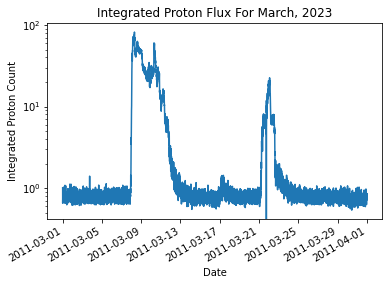

In [12]:
# Step Fourteen - Plot the datetimes and total flux values
ax = dfEH.plot(y='totflux',logy=True, title='Integrated Proton Flux For March, 2023',legend=False)
ax.set_xlabel('Date')
ax.set_ylabel('Integrated Proton Count')
ax.plot()